## Define Precursor Functions, Load Packages

In [1]:
import csv
import numpy as np;
import tensorflow as tf
import numpy as np
import math;
import random;
import matplotlib.pyplot as plt;
def Motif2PrecursorVec(promoter_seq):
    precursor = [];
    if True:#type(promoter_seq) == 'str':
        #print('here')
        promoter_seq = promoter_seq.lower()
        precursor = [None]*len(promoter_seq);
        seq_map = {'a':0.25,'c':0.5,'t':0.75,'g':1.0};
        for ind in range(0,len(promoter_seq)):
            precursor[ind] =seq_map[promoter_seq[ind]];
        return np.asarray(precursor,dtype=np.float32);
    else:
        return precursor;
    return precursor;
  

def gen_y_trace(num_tpoints,high=False):
    alpha = 0.1
    if high: 
        max_value = np.random.randn(1,1)[0][0]*1e-1 + 1e0
    else:
        max_value = np.random.randn(1,1)[0][0]*1e-2 + 1e-2
    output = [None]*num_tpoints;
    for t in range(0,num_tpoints):
        output[t] = max_value*1.0/(1.0+np.exp(-alpha*(t-50.0)))
        
    return np.asarray(output); 
    
def make_labeled_corpus(seq_list,stride_param):
    corpus = [];
    labels= [];
    for elem in seq_list:
        this_seq = elem[0];
        this_label = elem[1];
        for ind in range(0,len(this_seq)-stride_param+1):
            this_datapt = this_seq[ind:ind+stride_param];
            corpus.append(this_datapt);
            labels.append(this_label);
    return corpus,labels
    
    

In [2]:
Hits_Sequences=['chr1:91482587-91482628',
'chr3:121618056-121618097',
'chr7:105639099-105639140',
'chr13:71715246-71715287',
'chr15:84172724-84172765']

## Ingest Pinello Group (Harvard/MGH) Data

In [3]:
file_obj = open('CSVs/mgh_data.csv')  
csv_reader = csv.reader(file_obj);
all_lines = []; 
promoter_seq = 1; 
barcode = 0; 

for row in csv_reader:
    all_lines.append(row);
    
raw_data = all_lines[0:];
seq_val = [];
ctr = 0;
for row in raw_data:
    if ctr%2 ==0:
        if row[barcode][0:-1] in Hits_Sequences:
            seq_val.append([row[promoter_seq],1.0]);
        else:
            seq_val.append([row[promoter_seq],0.0]);
    ctr = ctr+1;
    

                

### Reduction of Data Set for Early Prototyping

In [4]:
seq_val = seq_val[0:30]

## Tensorflow Basics

In [5]:
def expose_deep_basis(z_list,num_bas_obs,deep_dict_size,iter_num,u):
    basis_hooks = z_list[-1]; #[-1] is y  = K *\phi; -2 is \phi(yk)
    x_range = np.arange(-10.0,10.0,0.1);

    for i in range(0,num_bas_obs):
        plt.close();
        scan_injection = np.zeros((len(x_range),num_bas_obs));
        scan_injection[:,i]= np.transpose(x_range);
        phi_j = basis_hooks.eval(feed_dict={u:scan_injection});
        fig_hand = plt.gcf()
        plt.plot(x_range,phi_j,'.-',label='\phi_i(y)');
        #plt.ylim([-2.0,2.0]);
        fig = plt.gcf();
        plt.savefig('deep_basis_images/phi_with_u' + repr(i) + '_iternum_' + repr(iter_num) + '.jpg');

    return fig_hand;        

def xavier_init(n_inputs, n_outputs, uniform=True):
    """Set the parameter initialization using the method described.
    This method is designed to keep the scale of the gradients roughly the same
    in all layers.
    Xavier Glorot and Yoshua Bengio (2010):
       Understanding the difficulty of training deep feedforward neural
       networks. International conference on artificial intelligence and
       statistics.
    Args:
    n_inputs: The number of input nodes into each output.
    n_outputs: The number of output nodes for each input.
    uniform: If true use a uniform distribution, otherwise use a normal.
    Returns:
    An initializer.
    """
    if uniform:
        # 6 was used in the paper.
        init_range = math.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limits as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = math.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

def weight_variable(shape):
    std_dev = math.sqrt(3.0 /(shape[0] + shape[1]))
    return tf.Variable(tf.truncated_normal(shape, mean=0.0,stddev=std_dev,dtype=tf.float32));
  
def bias_variable(shape):
    std_dev = math.sqrt(3.0 / shape[0])
    return tf.Variable(tf.truncated_normal(shape, mean=0.0,stddev=std_dev,dtype=tf.float32));


def network_assemble(input_var,W_list,b_list,keep_prob=1.0,activation_flag=1,res_net=0):
    n_depth = len(W_list);
    print("n_depth: " + repr(n_depth));
    z_temp_list = [];
    
    for k in range(0,n_depth):
        
        if (k==0):
            W1 = W_list[0];
            b1 = b_list[0];
            if activation_flag==1:# RELU
                z1 = tf.nn.dropout(tf.nn.relu(tf.matmul(input_var,W1)+b1),keep_prob);
            if activation_flag==2: #ELU 
                z1 = tf.nn.dropout(tf.nn.elu(tf.matmul(input_var,W1)+b1),keep_prob);
            if activation_flag==3: # tanh
                z1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(input_var,W1)+b1),keep_prob);

            z_temp_list.append(z1);
            

        if not (k==0) and k < (n_depth-1):
            
            prev_layer_output = tf.matmul(z_temp_list[k-1],W_list[k])+b_list[k]

            if res_net and k==(n_depth-2):
                prev_layer_output += tf.matmul(u,W1)+b1 #  this expression is not compatible for variable width nets (where each layer has a different width at inialization - okay with regularization and dropout afterwards though)

            if activation_flag==1:
                z_temp_list.append(tf.nn.dropout(tf.nn.relu(prev_layer_output),keep_prob));
            if activation_flag==2:
                z_temp_list.append(tf.nn.dropout(tf.nn.elu(prev_layer_output),keep_prob));
            if activation_flag==3:
                z_temp_list.append(tf.nn.dropout(tf.nn.tanh(prev_layer_output),keep_prob));

                
        if not (k==0) and k == (n_depth-1):
            prev_layer_output = tf.matmul(z_temp_list[k-1],W_list[k])+b_list[k];
            z_temp_list.append(prev_layer_output);

        
    if debug_splash:
        print("[DEBUG] z_list" + repr(z_list[-1]));
        
    #y_out = tf.concat([z_list[-1],u],axis=1); # last element of activation output list is the actual NN output
    y_out = z_temp_list[-1];
    
    result = sess.run(tf.global_variables_initializer())
    return y_out,z_temp_list;


def initialize_Wblist(n_u,hv_list):
    W_list = [];
    b_list = [];
    n_depth = len(hv_list);
    print("Length of hv_list: " + repr(n_depth))
    #hv_list[n_depth-1] = n_y;
    for k in range(0,n_depth):
        
        if k==0:
            W1 = weight_variable([n_u,hv_list[k]]);
            b1 = bias_variable([hv_list[k]]);
            W_list.append(W1);
            b_list.append(b1);
        else:
            W_list.append(weight_variable([hv_list[k-1],hv_list[k]]));
            b_list.append(bias_variable([hv_list[k]]));
    result = sess.run(tf.global_variables_initializer())
    return W_list,b_list;




In [6]:
def train_net(u_all_training,u_feed,obj_func,optimizer,u_control_all_training=None,valid_error_thres=1e-2,test_error_thres=1e-2,max_iters=100000,step_size_val=0.01,batchsize=10):

  iter = 0;
  samplerate = 5000;
  good_start = 1;
  valid_error = 100.0;
  test_error = 100.0;
  training_error_history_nocovar = [];
  validation_error_history_nocovar = [];
  test_error_history_nocovar = [];

  training_error_history_withcovar = [];
  validation_error_history_withcovar = [];
  test_error_history_withcovar = [];


  while (((test_error>test_error_thres) or (valid_error > valid_error_thres)) and iter < max_iters):
    iter+=1;
    
    all_ind = set(np.arange(0,len(u_all_training)));
    select_ind = np.random.randint(0,len(u_all_training),size=batchsize);
    valid_ind = list(all_ind -set(select_ind))[0:batchsize];
    select_ind_test = list(all_ind - set(valid_ind) - set(select_ind))[0:batchsize];

    
    u_batch =[];
    u_control_batch = [];
#    y_batch = [];
    u_valid = [];
    u_control_valid = [];
#    y_valid = [];
    u_test_train = [];
    u_control_train = [];
#    y_test_train= [];
    u_control_test_train = [];
    
    for j in range(0,len(select_ind)):
      u_batch.append(u_all_training[select_ind[j]]);
    
#    y_batch = embed_feed.eval(feed_dict={u_feed:u_batch});
    
#      y_batch.append(y_all_training[select_ind[j]]);
          
    for k in range(0,len(valid_ind)):
      u_valid.append(u_all_training[valid_ind[k]]);

#    y_valid = embed_feed.eval(feed_dict={u_feed:u_valid});


    for k in range(0,len(select_ind_test)):
      u_test_train.append(u_all_training[select_ind_test[k]]);

#    y_test_train = embed_feed.eval(feed_dict={u_feed:u_test_train});


    optimizer.run(feed_dict={u_feed:u_batch})#,embed_feed:,step_size:step_size_val});
    valid_error = obj_func.eval(feed_dict={u_feed:u_valid})#,embed_feed:y_valid});
    test_error = obj_func.eval(feed_dict={u_feed:u_test_train})#,embed_feed:y_test_train});

    
    if iter%samplerate==0:
      training_error_history_nocovar.append(obj_func.eval(feed_dict={u_feed:u_batch}))#,embed_feed:y_batch}));
      validation_error_history_nocovar.append(obj_func.eval(feed_dict={u_feed:u_valid}))#,embed_feed:y_valid}));
      test_error_history_nocovar.append(obj_func.eval(feed_dict={u_feed:u_test_train}))#,embed_feed:y_test_train}));

  
      if (iter%10==0) or (iter==1):
        #plt.close();                  
        print ("step %d , validation error %g"%(iter, obj_func.eval(feed_dict={u_feed:u_valid})))#,embed_feed:y_valid})));
        print ("step %d , test error %g"%(iter, obj_func.eval(feed_dict={u_feed:u_test_train})));#,embed_feed:y_test_train})));
        print("Reconstruction Loss: " + repr(this_vae_loss.eval(feed_dict={this_u:this_corpus_vec})))
#        this_corpus_embed = embed_feed.eval(feed_dict={u_feed:})
        print("Embedding Loss: " + repr(this_embed_loss.eval(feed_dict={this_u:this_corpus_vec})) )
    
#    if ((iter>20000) and iter%10) :#
#
#      valid_gradient = np.gradient(np.asarray(validation_error_history_nocovar[iter/samplerate*7/10:]));
#      mu_gradient = np.mean(valid_gradient);
#
#      if ((iter <1000) and (mu_gradient >= 5e-1)): # eventually update this to be 1/10th the mean of batch data, or mean of all data handed as input param to func
#        good_start = 0; # if after 10,000 iterations validation error is still above 1e0, initialization was poor.
#        print("Terminating model refinement loop with gradient:") + repr(mu_gradient) + ", validation error after " + repr(iter) + " epochs:  " + repr(valid_error);
#        iter = max_iters; # terminate while loop and return histories

  all_histories = [training_error_history_nocovar, validation_error_history_nocovar,test_error_history_nocovar];
  
  plt.close();
  x = np.arange(0,len(validation_error_history_nocovar),1);
  plt.plot(x,training_error_history_nocovar,label='train. err.');
  plt.plot(x,validation_error_history_nocovar,label='valid. err.');
  plt.plot(x,test_error_history_nocovar,label='test err.');
  #plt.gca().set_yscale('log');
  plt.savefig('all_error_history.pdf');
  
  plt.close();
  return all_histories,good_start;

In [7]:
def customLoss(y_model,y_true,embed_true):
    return vae_loss(y_model,y_true)+embed_loss(y_true,embed_true);

def vae_loss(y_model,y_true):
    return tf.norm(y_true - y_model,axis=[0,1],ord=2)/tf.norm(y_true,axis=[0,1],ord=2);

def embed_loss(y_true,embed_true):
    #y_true is (batch_size_param) x (dim of stride) tensor 
    IP_Matrix_y = tf.matmul(y_true,tf.transpose(y_true));
    IP_Matrix_e = tf.matmul(embed_true,tf.transpose(embed_true));
    Scale_Matrix_y = tf.diag(tf.norm(y_true,ord='euclidean',axis=1));
    Scale_Matrix_e = tf.diag(tf.norm(embed_true,ord='euclidean',axis=1));
    Ky = tf.matmul(tf.matmul(Scale_Matrix_y,IP_Matrix_y),Scale_Matrix_y);
    Ke = tf.matmul(tf.matmul(Scale_Matrix_e,IP_Matrix_e),Scale_Matrix_e);
    return tf.norm(IP_Matrix_y-IP_Matrix_e,axis=[0,1],ord='fro')/tf.norm(IP_Matrix_y,axis=[0,1],ord='fro')
    #return tf.norm(Ky-Ke,axis=[0,1],ord='fro')/tf.norm(Ky,axis=[0,1],ord='fro');#tf.norm(kernel_model - kernel_true,axis=[0,1],ord='fro')/tf.norm(kernel_true,axis=[0,1],ord='fro');

In [176]:
len(seq_val)

30

In [9]:
stride_parameter = 20; 
label_dim = 1; 
embedding_dim = 18;
intermediate_dim = 50;
batch_size_parameter=300;#4000 for howard's e. coli dataset
debug_splash = 0;
this_step_size_val = 0.25;

sess = tf.InteractiveSession();

In [10]:

def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
         # Fix the last sign such that the determinant is 1
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     # Equivalent to np.dot(np.diag(D), H) but faster, apparently
     H = (D*H.T).T
     return H

Rand_Transform = rvs(dim=stride_parameter)


In [11]:
this_corpus,this_labels = make_labeled_corpus(seq_val,stride_parameter)
this_corpus_vec = [];
for this_corpus_elem in this_corpus:    
    vec_value = Motif2PrecursorVec(this_corpus_elem);
    vec_value = np.dot(Rand_Transform,vec_value)
    
    this_corpus_vec.append(vec_value);

this_corpus_vec = np.asarray(this_corpus_vec);
from sklearn.preprocessing import MinMaxScaler
this_labels = np.expand_dims(this_labels,axis=1)
#this_labels=np.log10(this_labels);
#transformer = MinMaxScaler().fit(this_labels)
#this_labels = transformer.transform(this_labels)
#this_labels = np.asarray(this_labels)
print(len(this_labels))

660


In [12]:
hidden_vars_list = [embedding_dim,stride_parameter];
#hidden_vars_list = [intermediate_dim,intermediate_dim,intermediate_dim,embedding_dim,intermediate_dim,intermediate_dim,intermediate_dim,stride_parameter];
this_u = tf.placeholder(tf.float32, shape=[None,stride_parameter]);
with tf.device('/cpu:0'):
    this_W_list,this_b_list = initialize_Wblist(stride_parameter,hidden_vars_list);
    this_y_out,all_layers = network_assemble(this_u,this_W_list,this_b_list,keep_prob=1.0,activation_flag=2,res_net=0)
    
this_embedding = all_layers[-2]
regress_list = [intermediate_dim]*1+[label_dim]
with tf.device('/cpu:0'):
    this_Wregress_list,this_bregress_list = initialize_Wblist(embedding_dim,regress_list)
    #nonlinear_kernel,all_kernel_layers = network_assemble(this_embedding,this_Wregress_list,this_bregress_list,keep_prob=1.0,activation_flag=1,res_net=0)

#Winter = weight_variable((embedding_dim,intermediate_dim))
#biasinter = bias_variable([intermediate_dim])
#this_inter_out = tf.nn.dropout(tf.nn.relu(tf.matmul(this_embedding,Winter)+biasinter),keep_prob=1.0);
#Wproj = weight_variable((intermediate_dim,label_dim))
#biasproj = bias_variable([label_dim]);
#nonlinear_kernel = tf.nn.dropout(tf.nn.relu(tf.matmul(this_inter_out,Wproj)+biasproj),keep_prob=1.0);


    #this_kernel_label = tf.placeholder(tf.float32,shape=[None,label_dim]);
    HybridLoss = customLoss(this_y_out,this_u,this_embedding);
    result = sess.run(tf.global_variables_initializer())
    this_optim = tf.train.AdagradOptimizer(learning_rate=this_step_size_val).minimize(HybridLoss)
    step_size = tf.placeholder(tf.float32,shape=[]);
    result = sess.run(tf.global_variables_initializer())
    this_vae_loss = vae_loss(this_y_out,this_u)
    this_embed_loss = embed_loss(this_u,this_embedding);



    train_net(this_corpus_vec,this_u,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val*10.0,max_iters=5e4)
    train_net(this_corpus_vec,this_u,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val,max_iters=5e4)
    train_net(this_corpus_vec,this_u,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val*.5,max_iters=3e4)
    train_net(this_corpus_vec,this_u,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val*.1,max_iters=3e4)
    train_net(this_corpus_vec,this_u,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val*.05,max_iters=3e4)
    train_net(this_corpus_vec,this_u,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val*.01,max_iters=3e4)
    #train_net(this_corpus_vec,this_labels,this_u,this_kernel_label,HybridLoss,this_optim,batchsize = batch_size_parameter,step_size_val = this_step_size_val/2.0,max_iters=14e4)

Length of hv_list: 2
Instructions for updating:
Colocations handled automatically by placer.
n_depth: 2
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Length of hv_list: 2
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
step 5000 , validation error 0.0993109
step 5000 , test error 0.0926573
Reconstruction Loss: 0.06469977
Embedding Loss: 0.02965729
step 10000 , validation error 0.0889132
step 10000 , test error 0.0829148
Reconstruction Loss: 0.06271087
Embedding Loss: 0.020558462
step 15000 , validation error 0.0816741
step 15000 , test error 0.0780592
Reconstruction Loss: 0.06230529
Embedding Loss: 0.015760712
step 20000 , validation error 0.0781899
step 20000 , test error 0.071102
Reconstruction Loss: 0.062377665
Embedding L

In [13]:
print(this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}))
z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]})
print(this_corpus_vec[2])
print(this_corpus[2])

[[-0.16677147 -0.8657224   0.09397719  1.1238127  -0.18813789 -0.58989143
   0.42242104  0.42764312  0.24349229  0.2250545  -0.48617455 -0.29001546
   0.93774563  1.2296557   1.028988    0.48527864  0.24064586 -1.0628283
  -0.46075854  0.19422331]]
[-0.15884235 -0.87400403  0.07355026  1.09149164 -0.20245372 -0.6146602
  0.44352402  0.36908125  0.22114684  0.25097129 -0.48415268 -0.28329694
  0.88702354  1.24048285  1.04327834  0.54738201  0.22095563 -1.07255513
 -0.49949841  0.2201816 ]
TTCCTGCTTCATTCCCCTCT


In [14]:
SeqMap = ['A','C','T','G'];

def elemback2seq(this_elem):
    this_elem = this_elem[0];
    seq_dist_list = list(np.abs(np.array([this_elem]*4) - np.array([0.25,0.5,0.75,1.0])));
    #print(seq_dist_list)
    opt_index = seq_dist_list.index(np.min(np.array(seq_dist_list)));
    return(SeqMap[opt_index]);


def vecback2seq(untransformed_vec):
    # untransformed_vec is computed using the inverse of Rand_Transform to recover lattice-like vector representation/encoding
    seq_out = [elemback2seq(elem) for elem in untransformed_vec];
    return seq_out;

def num_mismatch(seq_model,seq_true):
    return np.sum(1*([not(seq_model[ind]==seq_true[ind]) for ind in range(0,len(seq_true))]));
    

0.8681818181818182

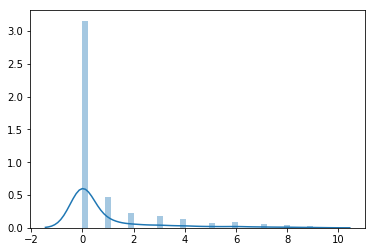

In [182]:
import seaborn as sns;
all_mismatches = []
for ind in range(0,len(this_corpus_vec)):
    z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[ind]]})
    this_seq_out = vecback2seq(np.dot(np.linalg.inv(Rand_Transform),z_ind.T))
    this_seq_out = ''.join(this_seq_out)
    all_mismatches.append(num_mismatch(this_seq_out,this_corpus[ind]));
hist_data = sns.distplot(all_mismatches)
mismatch_process = np.array(all_mismatches);
mismatch_process[mismatch_process<=2.0] = 1.0;
mismatch_process[mismatch_process>2.0] = 0.0;
np.sum(mismatch_process)/(len(mismatch_process)*1.0)

[0.27332672 0.14767832 0.07960831]
[16.983353 12.483626  9.165615]


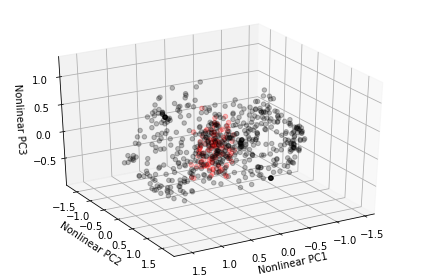

In [266]:
import matplotlib;
%matplotlib inline

subset_embeddings = this_embedding.eval(feed_dict={this_u:this_corpus_vec})

from sklearn.decomposition import PCA
X = subset_embeddings
pca = PCA(n_components=3)
pca.fit(X)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  
X_transformed = pca.transform(X)
X_transformed = X_transformed[0:]

X_transformed.shape

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

this_colors = 0.0*np.random.rand(len(X_transformed),3);

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for x_ind in range(0,len(X_transformed)):

    if this_labels[x_ind]==1.0:
        this_colors[x_ind][0] = 1.0;
    if this_labels[x_ind]==0.0:
        this_colors[x_ind][0] = 0.0;


ax.scatter(X_transformed[:,0], X_transformed[:,1],X_transformed[:,2], c=this_colors, marker='o',alpha=0.25)
    
ax.view_init(30, azim=420);

ax.set_xlabel('Nonlinear PC1')
ax.set_ylabel('Nonlinear PC2')
ax.set_zlabel('Nonlinear PC3')
plt.tight_layout()
plt.show();


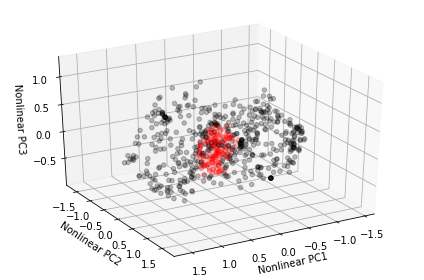

In [267]:
from sklearn.cluster import DBSCAN
import numpy as np

clustering = DBSCAN(eps=0.125, min_samples=7).fit(X_transformed)
clustering.labels_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

this_colors = 0.0*np.random.rand(len(X_transformed),3);

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
to_centroid = [];
for x_ind in range(0,len(X_transformed)):

    if clustering.labels_[x_ind]==0.0:
        this_colors[x_ind][0] = 1.0;
        to_centroid.append(X[x_ind])
    else:
        this_colors[x_ind][0] = 0.0;


ax.scatter(X_transformed[:,0], X_transformed[:,1],X_transformed[:,2], c=this_colors, marker='o',alpha=0.25)
    
ax.view_init(30, azim=420);

ax.set_xlabel('Nonlinear PC1')
ax.set_ylabel('Nonlinear PC2')
ax.set_zlabel('Nonlinear PC3')
plt.tight_layout()
plt.show();



In [261]:
temp_embed_vec = all_layers[0].eval(feed_dict={this_u:[this_corpus_vec[0]]})
print(all_layers[1].eval(feed_dict={this_embedding:temp_embed_vec}))



[[-0.06168504 -1.1854683  -0.02537398  1.2940644  -0.04684211 -0.8406686
   0.35801613 -0.11649337  0.13864212  0.14255734  0.08525512 -0.6746313
   0.79544985  1.3643385   0.9509399   0.26130518  0.6625361  -0.59570235
  -0.58650184  0.13434885]]


In [262]:
print(len(to_centroid))
cent_vec = np.mean(np.asarray(to_centroid),axis=0)
#for cent_vec in to_centroid:
#print(cent_vec)
recon_cent_vec = all_layers[1].eval(feed_dict={this_embedding:[cent_vec]})
this_seq_out = vecback2seq(np.dot(np.linalg.inv(Rand_Transform),recon_cent_vec.T))
print(''.join(this_seq_out))

18
CTCTTTCTTCCTTCCTTCCT


In [45]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0,).fit(X_transformed)
print(kmeans.labels_)
#kmeans.cluster_centers_


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [92]:
from sklearn.cluster import SpectralClustering
import numpy as np
clustering = SpectralClustering(n_clusters=2,n_init=1e6,gamma=1.0,affinity='rbf',assign_labels="discretize",random_state=0).fit(X_transformed)
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [112]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=1.2)
labels_050

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [50]:
this_labels.T

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

[0.27332675 0.14767836 0.07959107]
[16.983355 12.483628  9.164622]


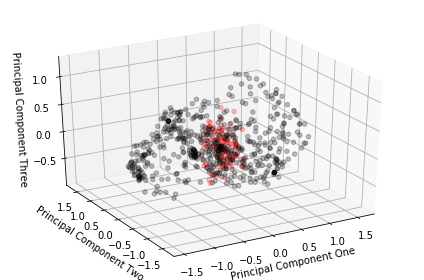

In [20]:
import matplotlib;
%matplotlib inline

subset_embeddings = this_embedding.eval(feed_dict={this_u:this_corpus_vec})

from sklearn.decomposition import PCA
X = subset_embeddings
pca = PCA(n_components=3)
pca.fit(X)  
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  
X_transformed = pca.transform(X)
X_transformed = X_transformed[0:]

X_transformed.shape

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

this_colors = 0.0*np.random.rand(len(X_transformed),3);

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for x_ind in range(0,len(X_transformed)):
    x= X_transformed[x_ind][0]
    y= X_transformed[x_ind][1]
    z= X_transformed[x_ind][2]
    if this_labels[x_ind]>0.66:
        this_colors[x_ind][0] = this_labels[x_ind];
    if 0.66>this_labels[x_ind]>0.33:
        this_colors[x_ind][1] = this_labels[x_ind];
    if 0.33>this_labels[x_ind]>-10.0:
        this_colors[x_ind][2] = this_labels[x_ind];
   

ax.scatter(X_transformed[:,0], X_transformed[:,1],X_transformed[:,2], c=this_colors, marker='o',alpha=0.25)
    
ax.view_init(30, azim=240);

ax.set_xlabel('Principal Component One')
ax.set_ylabel('Principal Component Two')
ax.set_zlabel('Principal Component Three')
plt.tight_layout()
plt.show();